In [1]:
import numpy as np
import pandas as pd
import librosa
import time
import matplotlib.pyplot as plt
import ESC3
import multiprocessing

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.compat.v1.keras.backend import set_session, clear_session, get_session
import gc

## Fold Training

In [2]:
fold_train_loss = []
fold_train_accuracy = []
fold_valid_loss = []
fold_valid_accuracy = []
fold_test = []

In [3]:
# Reset Keras Session
def reset_keras():
    
    # Get and close session
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
    
    # Garbage collector call
    gc.collect()
    
    # Init new session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [4]:
# Define training parameters
max_epochs = 800
lr = 0.00001
batch_size = 64

# Loop over the functions
for i in range(1, 6):
    
    # load the fold data
    train_d, train_l, val_d, val_l, test_d, test_l = ESC3.Load_Segments('ESC10', i)
    
    # Generate training and validation dataset
    training_dataset = ESC3.CreateTrainingSet10(train_d, train_l, name=f'train_MF{i}', batch_size=batch_size)
    validation_dataset = ESC3.CreateValidationSet(val_d, val_l, name=f'valid_MF{i}', batch_size=batch_size)
    
    # Initialize the network
    net = ESC3.PiczakNet10([60, 41, 3])
    loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    opt = tf.keras.optimizers.Adam(lr=lr)
    net.compile(optimizer=opt, loss=loss_f, metrics=["accuracy"])
    
    print(f'\n#############################################################')
    print(f'######################## FOLD-{i} #############################')
    print(f'#############################################################')
    # Train the network
    epoch_loss, epoch_acc, epoch_vl, epoch_va = ESC3.train(net, max_epochs, training_dataset, validation_dataset, batch_size=batch_size, verbose=True)
    
    # Append lossed for confidence plot
    fold_train_loss.append(epoch_loss)
    fold_train_accuracy.append(epoch_acc)
    fold_valid_loss.append(epoch_vl)
    fold_valid_accuracy.append(epoch_va)
    
    reset_keras()

    


#############################################################
######################## FOLD-1 #############################
#############################################################
Epoch  1: 	 t-loss: 2.315004 	 t-acc: 0.062500 	 v-loss: 2.296522 	 v-acc: 0.108432 	 time: 2.387
Epoch  2: 	 t-loss: 2.332351 	 t-acc: 0.109375 	 v-loss: 2.294251 	 v-acc: 0.112500 	 time: 0.578
Epoch  3: 	 t-loss: 2.361396 	 t-acc: 0.031250 	 v-loss: 2.293181 	 v-acc: 0.112500 	 time: 0.581
Epoch  4: 	 t-loss: 2.310665 	 t-acc: 0.125000 	 v-loss: 2.292994 	 v-acc: 0.112500 	 time: 0.585
Epoch  5: 	 t-loss: 2.316847 	 t-acc: 0.156250 	 v-loss: 2.293191 	 v-acc: 0.112500 	 time: 0.585
Epoch  6: 	 t-loss: 2.328232 	 t-acc: 0.078125 	 v-loss: 2.293164 	 v-acc: 0.112500 	 time: 0.581
Epoch  7: 	 t-loss: 2.339560 	 t-acc: 0.093750 	 v-loss: 2.292630 	 v-acc: 0.112500 	 time: 0.582
Epoch  8: 	 t-loss: 2.342213 	 t-acc: 0.109375 	 v-loss: 2.291428 	 v-acc: 0.112500 	 time: 0.586
Epoch  9: 	 t-loss: 2.287046 

In [5]:
# Convert lists to array
fold_train_loss = np.asarray(fold_train_loss)
fold_train_accuracy = np.asarray(fold_train_accuracy)
fold_valid_loss = np.asarray(fold_valid_loss)
fold_valid_accuracy = np.asarray(fold_valid_accuracy)

# Compute mean and confidence interval
m_tl = []
m_ta = []
m_vl = []
m_va = []

ci_tl = []
ci_ta = []
ci_vl = []
ci_va = []

for i in range(max_epochs):
    m_tl.append(np.mean(fold_train_loss[:, i]))
    m_ta.append(np.mean(fold_train_accuracy[:, i]))
    m_vl.append(np.mean(fold_valid_loss[:, i]))
    m_va.append(np.mean(fold_valid_accuracy[:, i]))
    
    ci_tl.append(1.96*np.std(fold_train_loss[:, i])/np.mean(fold_train_loss[:, i]))
    ci_ta.append(1.96*np.std(fold_train_accuracy[:, i])/np.mean(fold_train_accuracy[:, i]))
    ci_vl.append(1.96*np.std(fold_valid_loss[:, i])/np.mean(fold_valid_loss[:, i]))
    ci_va.append(1.96*np.std(fold_valid_accuracy[:, i])/np.mean(fold_valid_accuracy[:, i]))

m_tl = np.asarray(m_tl)
m_ta = np.asarray(m_ta)
m_vl = np.asarray(m_vl)
m_va = np.asarray(m_va)

ci_tl = np.asarray(ci_tl)
ci_ta = np.asarray(ci_ta)
ci_vl = np.asarray(ci_vl)
ci_va = np.asarray(ci_va)

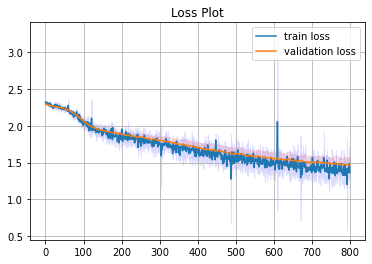

In [6]:
# Plot loss
fig, ax = plt.subplots()
ax.plot(m_tl, label='train loss')
ax.fill_between(np.arange(0, max_epochs), (m_tl-ci_tl), (m_tl+ci_tl), color='b', alpha=.1)
ax.plot(m_vl, label='validation loss')
ax.fill_between(np.arange(0, max_epochs), (m_vl-ci_vl), (m_vl+ci_vl), color='r', alpha=.1)
plt.grid()
plt.legend()
plt.title('Loss Plot')
plt.show()

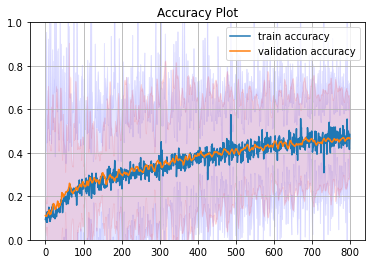

In [7]:
# Plot accuracy
fig, ax = plt.subplots()
ax.plot(m_ta, label='train accuracy')
ax.fill_between(np.arange(0, max_epochs), (m_ta-ci_ta), (m_ta+ci_ta), color='b', alpha=.1)
ax.plot(m_va, label='validation accuracy')
ax.fill_between(np.arange(0, max_epochs), (m_va-ci_va), (m_va+ci_va), color='r', alpha=.1)
plt.grid()
plt.legend()
plt.ylim(0, 1)
plt.title('Accuracy Plot')
plt.show()

In [8]:
# Find the best point before overfit on each run

# Retrain the network until that point

# Evaluate on the test set